---
# <span style='color:#2a54b2;;font-family:Verdana'><center><b>1. VAERS - Entre el Dato y la Desinformación
---

<blockquote><p style="font-family:Verdana; font-size:15px; color:darkblue"><b><i>
"Empezamos mal, si vamos por ahí", pensará más de uno.<br>
Bueno, no nos escandalicemos aún. Soy consciente de que no le podemos dar demasiada credibilidad a los reportes del VAERS, pero he encontrado cosas interesantes en sus datasets, que creo que tampoco podemos descartar directamente.<br><br>
He de decir que mi idea original para este proyecto era comprobar correlaciones entre la vacunación y la incidencia de ciertas enfermedades y dolencias que se están asociando a las vacunas de la COVID-19 (equivocadamente o no), pero no he encontrado datos para corroborarlo en la realidad, así que me centraré exclusivamente en los fallecimientos, de los que sí he encontrado datos oficiales, aunque no todo los completos que hubiera deseado.<br>
En el VAERS se especifican todo tipo de efectos adversos, que no han acabado en fallecimiento del paciente (al menos al momento de realizar el reporte), pero en este notebook solamente analizaré la cantidad de reportes totales realizados (incluyendo muertes) por cada año y por cada tipo de vacuna, y luego pondré el foco en los fallecimientos, que nos darán una pista para continuar la "investigación".<br>
Por cierto, a quien no esté dispuesto a embarrarse le sugiero que pare de leer aquí mismo, porque el camino que vamos a recorrer es pantanoso, y lo será más a cada paso que demos...

---
Los archivos CSV que voy a utlizar en este notebook pueden descargase desde el siguiente enlace:  
https://vaers.hhs.gov/data/datasets.html

<img src="input/logos/vaers_logo.jpeg"/>

Detalle de las columnas que voy a utilizar:
- **VAERS_ID** - Identificador único, que se usa para cruzar datos de las diferentes tablas.
- **VAX_TYPE** - Tipo de vacuna (las vacunas similares son agrupadas).
- **RECVDATE** - Fecha en la que el reporte fue recibido por VAERS.
- **DIED** - Especifica si el receptor de la vacuna murió o no.
- **DATEDIED** - Fecha de fallecimiento del receptor de la vacuna.
- **VAX_DATE** - Fecha en la que el receptor fue vacunado.
---

In [1]:
# Importo las librerías que voy a utilizar:
import pandas
import matplotlib.pyplot as plt
import seaborn as sbrn
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
# Deshabilito el "chained_assignment", para que no devuelva warnings en algunas modificaciones de columnas:
pandas.set_option('chained_assignment', None)

Importo todos los archivos CSV de VAERS (correspondientes al rango **1990-2021**), y los uno mediante la función **merge**, para tener acceso al tipo de vacuna (que solo consta en los archivos **VAERSVAX**):

In [3]:
# Itero un rango de números correspondiente a los años de los CSV de VAERS:
for year in range(1990, 2022):
    
    # Construyo los comandos para importar los CSV "VAERSVAX" y "VAERSDATA" (fliltrando las columnas), y para unirlos mediante la función "merge":
    import_vax_csv_code = f"vaers_{year}_vax = pandas.read_csv('./input/vaers/{year}VAERSVAX.csv', usecols=['VAERS_ID','VAX_TYPE'], encoding='ISO-8859-1', low_memory=False)"
    import_data_csv_code = f"vaers_{year}_data = pandas.read_csv('./input/vaers/{year}VAERSDATA.csv', usecols=['VAERS_ID','RECVDATE','DIED','DATEDIED','VAX_DATE'], encoding='ISO-8859-1', low_memory=False)"
    merge_code = f"vaers_{year} = pandas.merge(vaers_{year}_data, vaers_{year}_vax, on='VAERS_ID', how='left')"

    # Ejecuto los 3 comandos almacenados:
    exec(import_vax_csv_code)
    exec(import_data_csv_code)
    exec(merge_code)

Concatendo los dataframes finales correspondientes a cada año, para crear el dataframe final:

In [4]:
vaers_all = pandas.concat([vaers_1990, vaers_1991, vaers_1992, vaers_1993, vaers_1994, vaers_1995, vaers_1996, vaers_1997, vaers_1998, vaers_1999,
                               vaers_2000, vaers_2001, vaers_2002, vaers_2003, vaers_2004, vaers_2005, vaers_2006, vaers_2007, vaers_2008, vaers_2009,
                               vaers_2010, vaers_2011, vaers_2012, vaers_2013, vaers_2014, vaers_2015, vaers_2016, vaers_2017, vaers_2018, vaers_2019, vaers_2020, vaers_2021], ignore_index=True)
vaers_all

,VAERS_ID,RECVDATE,DIED,DATEDIED,VAX_DATE,VAX_TYPE
0,25001,07/02/1990,NaN,NaN,06/04/1990,DTP
1,25003,07/02/1990,Y,NaN,01/29/1990,DTP
2,25003,07/02/1990,Y,NaN,01/29/1990,OPV
3,25004,07/02/1990,NaN,NaN,11/13/1989,OPV
4,25005,07/02/1990,NaN,NaN,NaN,TD
...,...,...,...,...,...,...
1847285,1939059,12/10/2021,NaN,NaN,08/19/2021,COVID19
1847286,1939060,12/10/2021,NaN,NaN,12/09/2021,COVID19
1847287,1939061,12/10/2021,NaN,NaN,12/08/2021,COVID19
1847288,1939062,12/10/2021,NaN,NaN,12/09/2021,COVID19


Compruebo los **tipos de datos** de las columas:

In [5]:
vaers_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847290 entries, 0 to 1847289
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   VAERS_ID  int64 
 1   RECVDATE  object
 2   DIED      object
 3   DATEDIED  object
 4   VAX_DATE  object
 5   VAX_TYPE  object
dtypes: int64(1), object(5)
memory usage: 84.6+ MB


Compruebo los **valores null**:

In [6]:
vaers_all.isna().sum()

VAERS_ID          0
RECVDATE          0
DIED        1825710
DATEDIED    1828108
VAX_DATE     158778
VAX_TYPE          1
dtype: int64

Convierto las colulmnas **RECVDATE**, **DATEDIED** y **VAX_DATE** a tipo de datos **datetime64**:

In [7]:
vaers_all['RECVDATE'] = vaers_all['RECVDATE'].astype('datetime64')
vaers_all['DATEDIED'] = vaers_all['DATEDIED'].astype('datetime64')
vaers_all['VAX_DATE'] = vaers_all['VAX_DATE'].astype('datetime64')

Si el valor de la columna **DIED** es **Y**, lo sustituyo por **1**, y relleno los nulls de esa columna con el valor **0** (esto hace que el tipo de datos de la columna se convierta automáticamente a **int64**):

In [8]:
# Si el valor de la columna 'DIED' es "Y", lo sustituyo por "1":
vaers_all.loc[vaers_all['DIED'] == 'Y', 'DIED'] = 1

# Relleno los valores null con el valor "0":
vaers_all['DIED'].fillna(0, inplace=True)

Vuelvo a comprobar los tipos de datos, para confirmar que los cambios se aplicaron correctamente:

In [9]:
vaers_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847290 entries, 0 to 1847289
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   VAERS_ID  int64         
 1   RECVDATE  datetime64[ns]
 2   DIED      int64         
 3   DATEDIED  datetime64[ns]
 4   VAX_DATE  datetime64[ns]
 5   VAX_TYPE  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 84.6+ MB


Aun hay **valores null** en dos columnas de tipo **datetime**, pero de momento las dejo así (aparte, es normal que haya nulls en la columna **DATEDIED**):

In [10]:
vaers_all.isna().sum()

VAERS_ID          0
RECVDATE          0
DIED              0
DATEDIED    1828108
VAX_DATE     158778
VAX_TYPE          1
dtype: int64

Vuelvo a imprimir el dataframe:

Creo la columna **YEAR**, para almacenar el año, que extraigo de la columna **RECVDATE**:

In [11]:
vaers_all['YEAR'] = vaers_all['RECVDATE'].dt.year

vaers_all

,VAERS_ID,RECVDATE,DIED,DATEDIED,VAX_DATE,VAX_TYPE,YEAR
0,25001,1990-07-02,0,NaT,1990-06-04,DTP,1990
1,25003,1990-07-02,1,NaT,1990-01-29,DTP,1990
2,25003,1990-07-02,1,NaT,1990-01-29,OPV,1990
3,25004,1990-07-02,0,NaT,1989-11-13,OPV,1990
4,25005,1990-07-02,0,NaT,NaT,TD,1990
...,...,...,...,...,...,...,...
1847285,1939059,2021-12-10,0,NaT,2021-08-19,COVID19,2021
1847286,1939060,2021-12-10,0,NaT,2021-12-09,COVID19,2021
1847287,1939061,2021-12-10,0,NaT,2021-12-08,COVID19,2021
1847288,1939062,2021-12-10,0,NaT,2021-12-09,COVID19,2021


Hago una agrupación en base a la columna **YEAR** (con la función **size**), para comprobar la cantidad de reportes de efectos adversos por año:

In [12]:
vaers_all.groupby('YEAR').size()

YEAR
1990      2787
1991     16657
1992     18392
1993     17655
1994     18441
1995     17794
1996     17592
1997     17247
1998     15997
1999     20072
2000     23113
2001     25492
2002     26852
2003     31248
2004     28663
2005     28664
2006     31353
2007     48349
2008     51020
2009     50525
2010     49602
2011     41201
2012     41150
2013     43336
2014     47166
2015     57224
2016     60450
2017     52752
2018     62305
2019     61203
2020     60226
2021    762762
dtype: int64

Hago un **countplot**, para visualizar dichos valores en una gráfica:

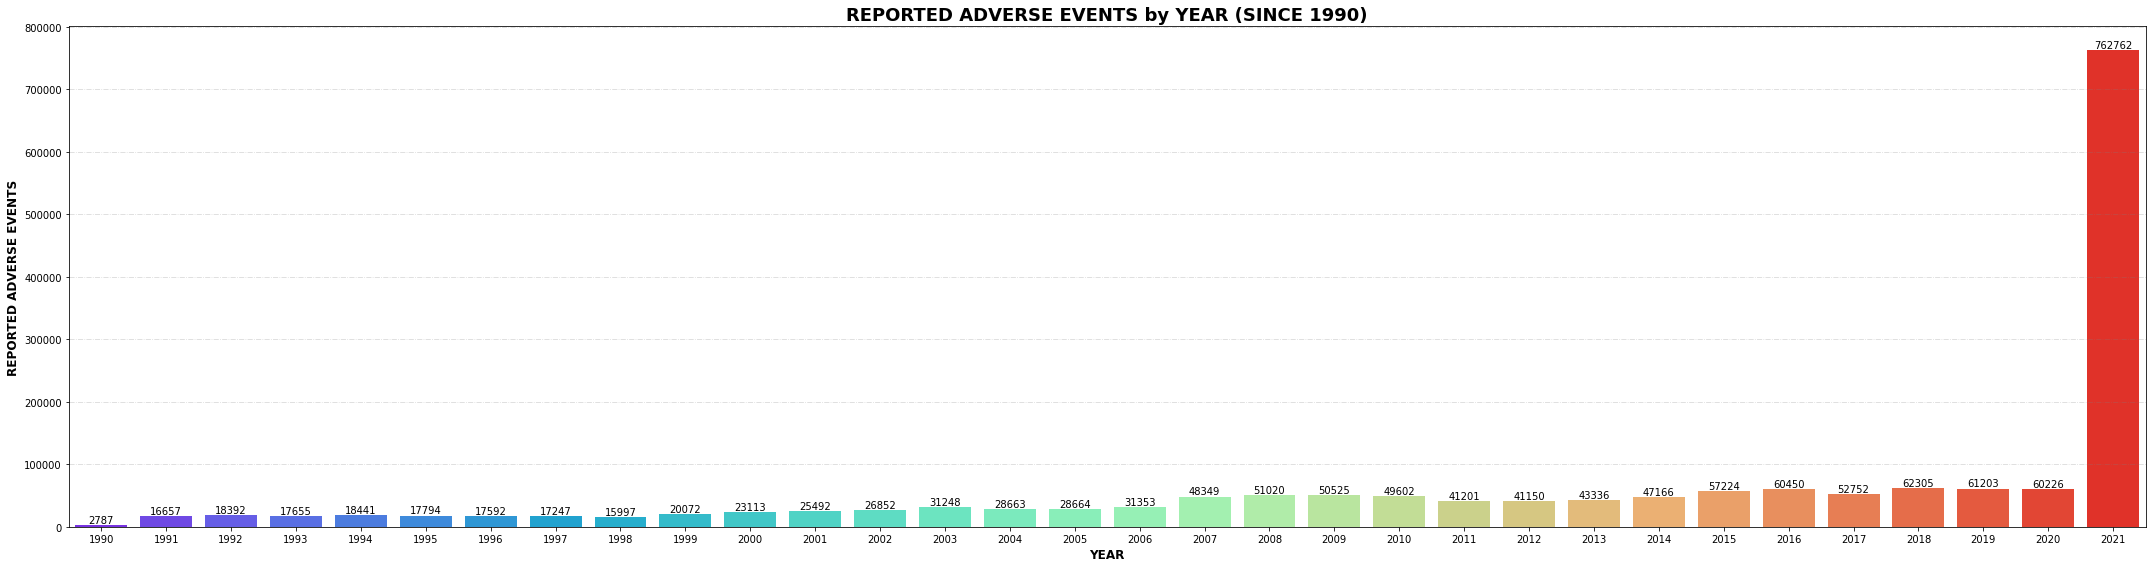

In [13]:
plt.figure(figsize = (30, 8))

ax = sbrn.countplot(x='YEAR', data=vaers_all, palette='rainbow')

for container in ax.containers:
    ax.bar_label(container)

plt.title('REPORTED ADVERSE EVENTS by YEAR (SINCE 1990)', fontweight='bold', fontsize=18)
plt.xlabel('YEAR', fontweight='bold', fontsize=12)
plt.ylabel('REPORTED ADVERSE EVENTS', fontweight='bold', fontsize=12)
ax.grid(axis='y', color='gray', linestyle='dashdot', alpha=0.3)
plt.tight_layout();

<blockquote><p style="font-family:Verdana; font-size:15px; color:darkblue"><b><i>
Pues aunque tengamos en cuenta que no podemos fiarnos mucho de los reportes del VAERS, la diferencia entre la cantidad de reportes que se hicieron en 2021 y los que se hicieron el resto de años es tremendamente llamativa.<br>
Puede que esto en el fondo no signifique nada, pero no podemos descartarlo.

Hago una agrupación en base a la columna **VAX_TYPE** (con la función **size**), para comprobar la cantidad de reportes de efectos adversos por tipo de vacuna:

In [14]:
vaers_all.groupby('VAX_TYPE').size().sort_values(ascending=False).head(20)

VAX_TYPE
COVID19    721069
VARZOS      97925
FLU3        93339
VARCEL      80074
MMR         77382
PPV         60898
HEP         59640
DTAP        56869
HIBV        49226
TDAP        39119
HEPA        37722
HPV4        37036
IPV         36802
FLU4        34703
PNC13       27925
MNQ         24498
OPV         23699
PNC         23364
FLUX        21323
DTP         20793
dtype: int64

Hago un **barplot**, para visualizar dichos valores en una gráfica (estableciendo un **mínimo de 1000 reportes**):

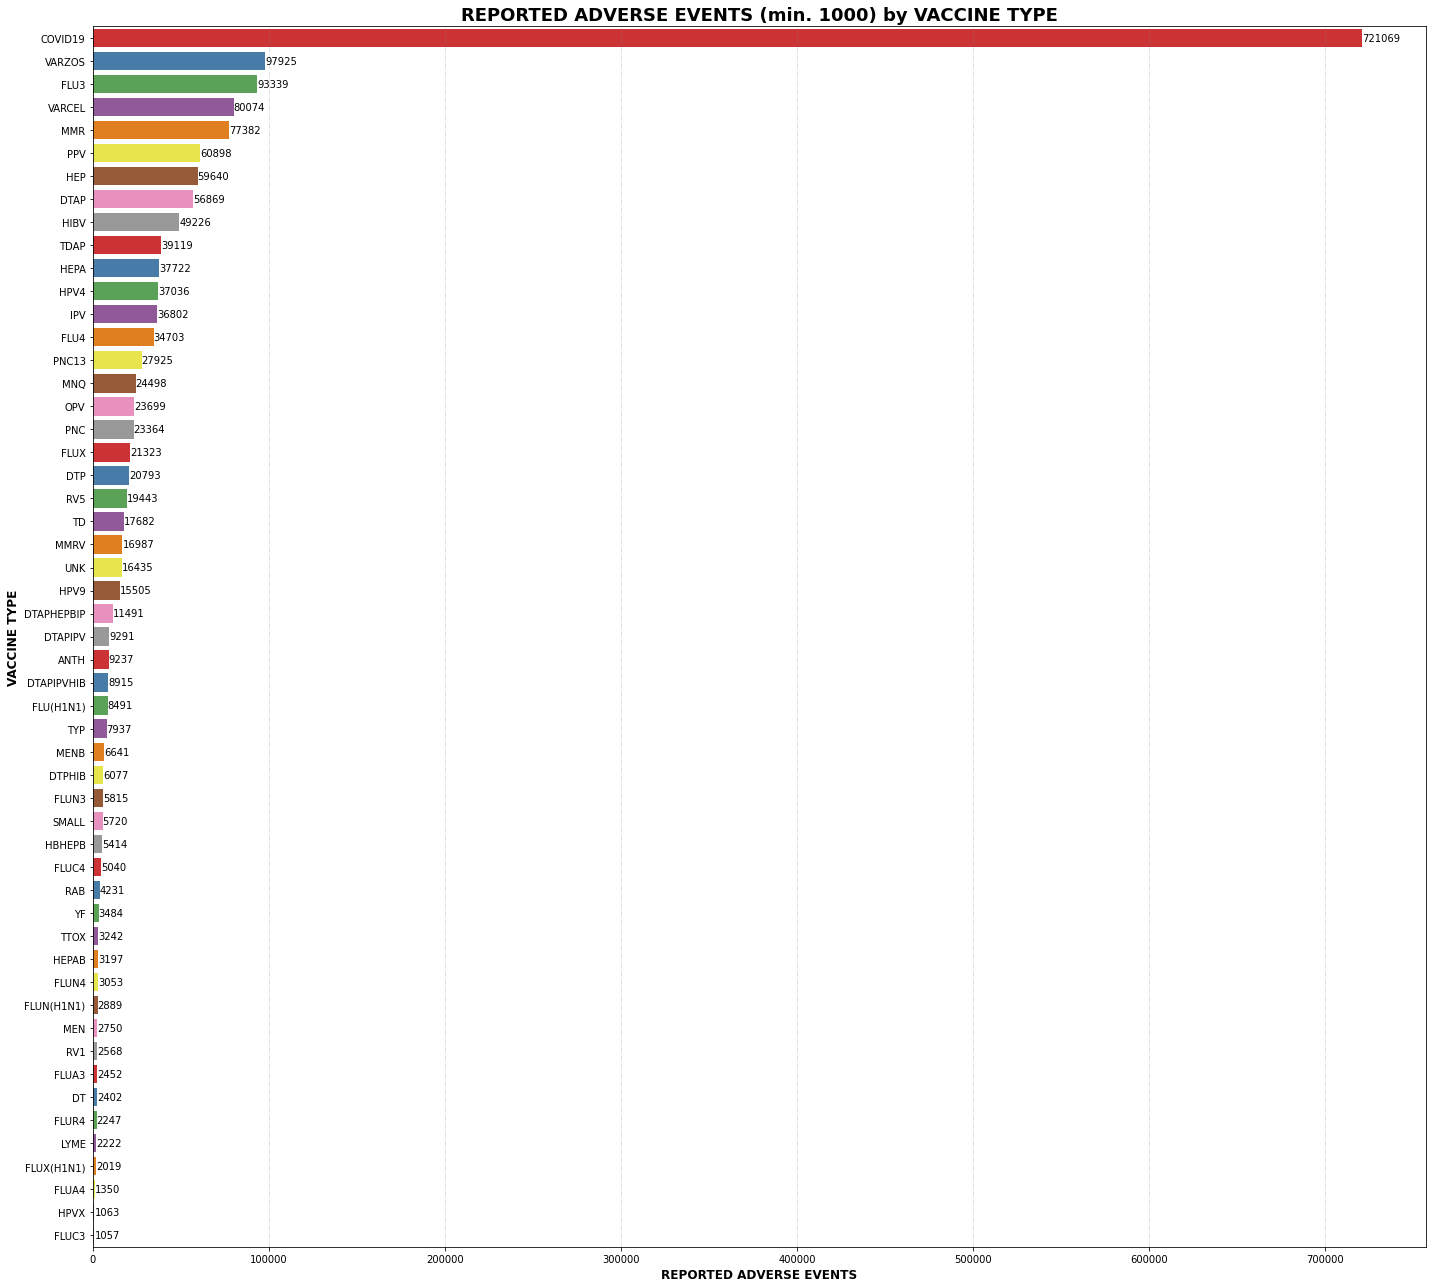

In [15]:
plt.figure(figsize = (20, 18))

# Creo un dataframe con una agrupación (con un mínimo de 1000 efectos adversos):
grouped_df = vaers_all.groupby('VAX_TYPE').count().query("VAERS_ID > 1000").reset_index()

ax = sbrn.barplot(x='VAERS_ID', y='VAX_TYPE', data=grouped_df.sort_values(by='VAERS_ID', ascending=False), palette='Set1')

for container in ax.containers:
    ax.bar_label(container)
    
plt.title('REPORTED ADVERSE EVENTS (min. 1000) by VACCINE TYPE', fontweight='bold', fontsize=18)
plt.xlabel('REPORTED ADVERSE EVENTS', fontweight='bold', fontsize=12)
plt.ylabel('VACCINE TYPE', fontweight='bold', fontsize=12)
ax.grid(axis='x', color='gray', linestyle='dashdot', alpha=0.3)
plt.tight_layout();

<blockquote><p style="font-family:Verdana; font-size:15px; color:darkblue"><b><i>
Como era de esperar, la inmensa mayoría de los reportes de efectos adversos realizados en 2021 corresponden a las vacunas de la COVID-19, pero es llamativo que estas vacunas superen de forma tan exagerada a todas las demás, sobretodo teniendo en cuenta que estamos analizando nada menos que 30 años de reportes.
</b></div>

Hago una agrupación en base a la columna **VAX_TYPE** (con la función **sum**), y mostrando solo la columna **DIED**, para comprobar la cantidad de reportes de fallecimientos por tipo de vacuna:

In [16]:
vaers_all.groupby('VAX_TYPE')['DIED'].sum().sort_values(ascending=False).head(20)

VAX_TYPE
COVID19       10818
HIBV           1371
HEP             906
OPV             839
DTAP            694
PNC             687
DTP             672
FLU3            646
IPV             577
DTAPHEPBIP      408
PNC13           400
RV5             373
FLUX            303
MMR             256
VARZOS          233
UNK             225
DTAPIPVHIB      223
DTPHIB          222
PPV             201
HPV4            193
Name: DIED, dtype: int64

Hago un **barplot**, para visualizar dichos valores en una gráfica (estableciendo un **mínimo de 50 fallecimientos** reportados):

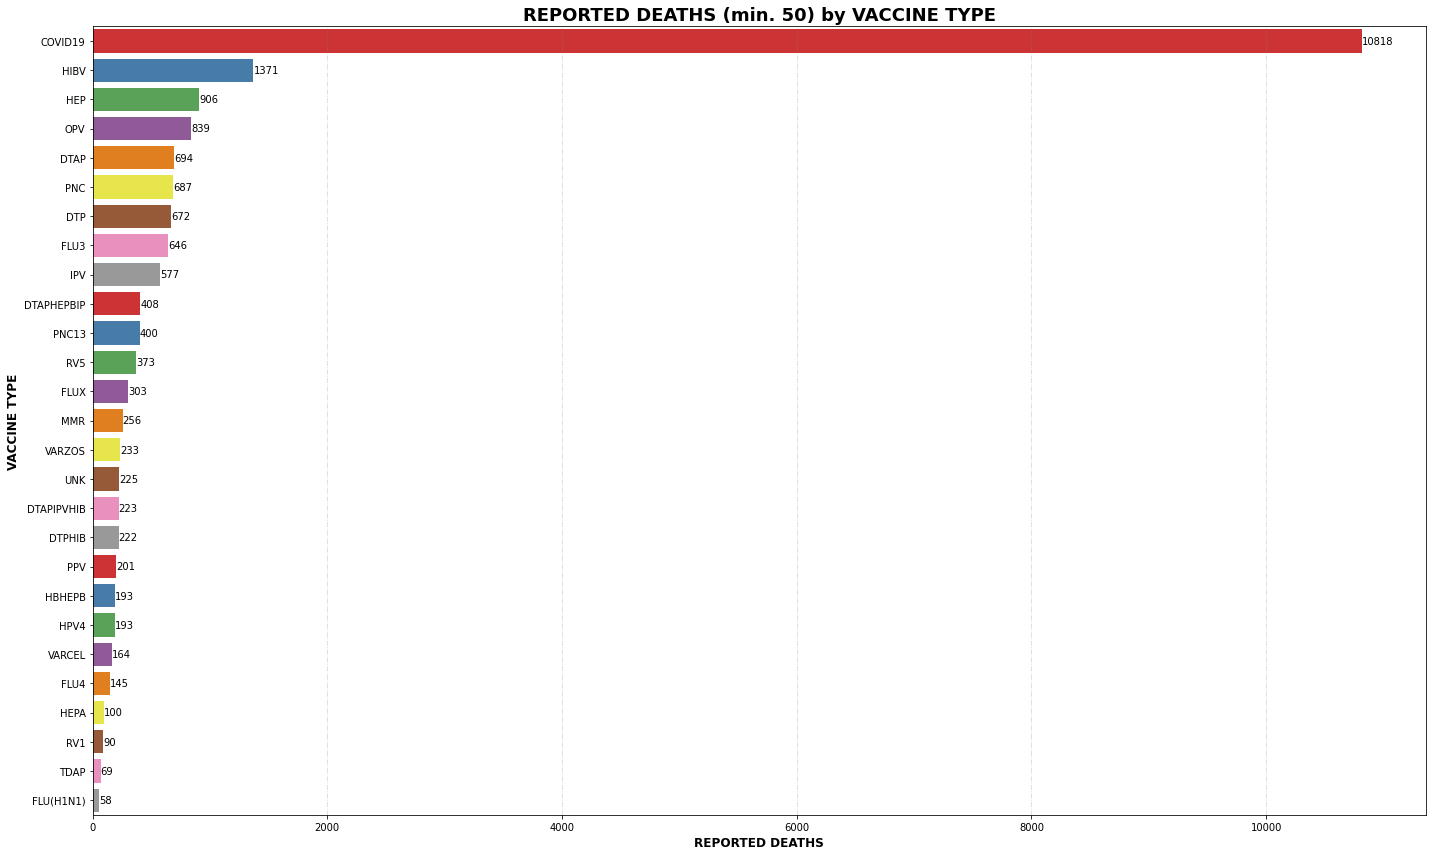

In [17]:
plt.figure(figsize = (20, 12))

# Creo un dataframe con una agrupación (con un mínimo de 50 muertes):
grouped_df = vaers_all.groupby('VAX_TYPE').sum().query("DIED > 50").reset_index()

ax = sbrn.barplot(x='DIED', y='VAX_TYPE', data=grouped_df.sort_values(by='DIED', ascending=False), palette='Set1')

for container in ax.containers:
    ax.bar_label(container)
    
plt.title('REPORTED DEATHS (min. 50) by VACCINE TYPE', fontweight='bold', fontsize=18)
plt.xlabel('REPORTED DEATHS', fontweight='bold', fontsize=12)
plt.ylabel('VACCINE TYPE', fontweight='bold', fontsize=12)
ax.grid(axis='x', color='gray', linestyle='dashdot', alpha=0.3)
plt.tight_layout();

<blockquote><p style="font-family:Verdana; font-size:15px; color:darkblue"><b><i>
Pues lo mismo pasa con los fallecimientos reportados.<br>
La relación entre la vacuna de la COVID-19 y las demás es muy similar a la que tienen con respecto a todos los efectos adversos reportados.

Guardo en otro dataframe los reportes correspondientes a vacunas de tipo **COVID19**, con resultado de **fallecimiento** (y con fecha de vacunación y de fallecimiento informadas):

In [18]:
covidvax_deaths = vaers_all.query("VAX_TYPE == 'COVID19' and DIED == 1 and DATEDIED.notna() and VAX_DATE.notna()")

covidvax_deaths

,VAERS_ID,RECVDATE,DIED,DATEDIED,VAX_DATE,VAX_TYPE,YEAR
1077356,909095,2020-12-25,1,2020-12-25,2020-12-23,COVID19,2020
1078530,910363,2020-12-28,1,2020-12-28,2020-12-23,COVID19,2020
1081115,913143,2020-12-29,1,2020-12-29,2020-12-29,COVID19,2020
1081690,913733,2020-12-30,1,2020-12-29,2020-12-29,COVID19,2020
1082540,914604,2020-12-30,1,2020-12-20,2020-12-16,COVID19,2020
...,...,...,...,...,...,...,...
1846227,1936547,2021-12-09,1,2021-05-15,2021-02-17,COVID19,2021
1846228,1936547,2021-12-09,1,2021-05-15,2021-02-17,COVID19,2021
1846318,1936717,2021-12-09,1,2021-09-30,2021-09-16,COVID19,2021
1846332,1936730,2021-12-09,1,2021-12-08,2021-03-26,COVID19,2021


Creo la columna **DAYS_TO_DEATH**, para reflejar los días transcurridos desde la vacunación al fallecimiento:

In [19]:
covidvax_deaths['DAYS_TO_DEATH'] = (covidvax_deaths['DATEDIED'] - covidvax_deaths['VAX_DATE']).dt.days

covidvax_deaths

,VAERS_ID,RECVDATE,DIED,DATEDIED,VAX_DATE,VAX_TYPE,YEAR,DAYS_TO_DEATH
1077356,909095,2020-12-25,1,2020-12-25,2020-12-23,COVID19,2020,2
1078530,910363,2020-12-28,1,2020-12-28,2020-12-23,COVID19,2020,5
1081115,913143,2020-12-29,1,2020-12-29,2020-12-29,COVID19,2020,0
1081690,913733,2020-12-30,1,2020-12-29,2020-12-29,COVID19,2020,0
1082540,914604,2020-12-30,1,2020-12-20,2020-12-16,COVID19,2020,4
...,...,...,...,...,...,...,...,...
1846227,1936547,2021-12-09,1,2021-05-15,2021-02-17,COVID19,2021,87
1846228,1936547,2021-12-09,1,2021-05-15,2021-02-17,COVID19,2021,87
1846318,1936717,2021-12-09,1,2021-09-30,2021-09-16,COVID19,2021,14
1846332,1936730,2021-12-09,1,2021-12-08,2021-03-26,COVID19,2021,257


Compruebo que hay valores negativos en la nueva columna, y eso no puede ser correcto:

In [20]:
covidvax_deaths['DAYS_TO_DEATH'].unique()

array([     2,      5,      0,      4,      3,      1,     10,     12,
           11,    368,      6,      7,      8,      9,     16,  -7304,
           13,     20,     19,     15,    -29,     17,     23,     28,
           26,     18,     21,     22,     14,     27,    -10,     24,
        36896,     31,     -6,     25,     29,     -2,     35,     44,
           62,    -24,     -4,     -8,     37,     -5,     42,     36,
           49,     34,     40,     30,    -12,    354,     38,    -19,
          -13,  -2549,     32,     33,    -15,     39,     48,     41,
           46,     50,     52,     59,     66,     58,     54,    367,
           51,    -23,     43,    352,    -20,     65,     61,     47,
           60,     -9,     72,     55,     45,     82,    -16,     57,
           56,     77,     64,    100,    -18,     83,     81,    136,
           -1,  19420,     76,     68,    384,     63,     74,     80,
           67,     53,     99,    122,     71,     73,     89,     75,
      

Compruebo esos registros, y veo que tienen fechas mal informadas:

In [21]:
covidvax_deaths.query("DAYS_TO_DEATH < 0")

,VAERS_ID,RECVDATE,DIED,DATEDIED,VAX_DATE,VAX_TYPE,YEAR,DAYS_TO_DEATH
1099790,930912,2021-01-09,1,2001-01-08,2021-01-07,COVID19,2021,-7304
1120988,952204,2021-01-18,1,2020-12-01,2020-12-30,COVID19,2021,-29
1133303,965910,2021-01-22,1,2021-01-01,2021-01-11,COVID19,2021,-10
1142357,975421,2021-01-26,1,2021-01-01,2021-01-07,COVID19,2021,-6
1152910,986869,2021-01-29,1,2021-01-01,2021-01-03,COVID19,2021,-2
1167216,1003624,2021-02-04,1,2021-01-01,2021-01-25,COVID19,2021,-24
1168566,1005377,2021-02-05,1,2021-01-01,2021-01-05,COVID19,2021,-4
1173409,1020134,2021-02-07,1,2021-01-20,2021-01-28,COVID19,2021,-8
1180265,1019661,2021-02-10,1,2021-02-01,2021-02-06,COVID19,2021,-5
1193202,1034146,2021-02-16,1,2021-02-01,2021-02-13,COVID19,2021,-12


Así que elimino esos registros, seleccionando solo los que tienen valor igual o superior a **0** en la columna **DAYS_TO_DEATH**:

In [22]:
covidvax_deaths = covidvax_deaths.query("DAYS_TO_DEATH >= 0")

covidvax_deaths

,VAERS_ID,RECVDATE,DIED,DATEDIED,VAX_DATE,VAX_TYPE,YEAR,DAYS_TO_DEATH
1077356,909095,2020-12-25,1,2020-12-25,2020-12-23,COVID19,2020,2
1078530,910363,2020-12-28,1,2020-12-28,2020-12-23,COVID19,2020,5
1081115,913143,2020-12-29,1,2020-12-29,2020-12-29,COVID19,2020,0
1081690,913733,2020-12-30,1,2020-12-29,2020-12-29,COVID19,2020,0
1082540,914604,2020-12-30,1,2020-12-20,2020-12-16,COVID19,2020,4
...,...,...,...,...,...,...,...,...
1846227,1936547,2021-12-09,1,2021-05-15,2021-02-17,COVID19,2021,87
1846228,1936547,2021-12-09,1,2021-05-15,2021-02-17,COVID19,2021,87
1846318,1936717,2021-12-09,1,2021-09-30,2021-09-16,COVID19,2021,14
1846332,1936730,2021-12-09,1,2021-12-08,2021-03-26,COVID19,2021,257


Hago una agrupación en base a la columna **DAYS_TO_DEATH** (con la función **size**), para comprobar la cantidad de reportes de fallecimientos por días transcurridos desde la vacunación:

In [23]:
covidvax_deaths.groupby('DAYS_TO_DEATH').size().head(30)

DAYS_TO_DEATH
0     305
1     634
2     412
3     297
4     250
5     219
6     165
7     198
8     135
9     160
10    133
11    120
12    133
13    118
14    118
15    123
16    101
17     83
18     93
19    115
20     92
21    112
22     92
23     70
24     76
25     64
26     64
27     89
28     68
29     61
dtype: int64

Hago un **countplot**, para visualizar dichos valores en una gráfica (estableciendo un **máximo de 60 días transcurridos desde la vacunación**):

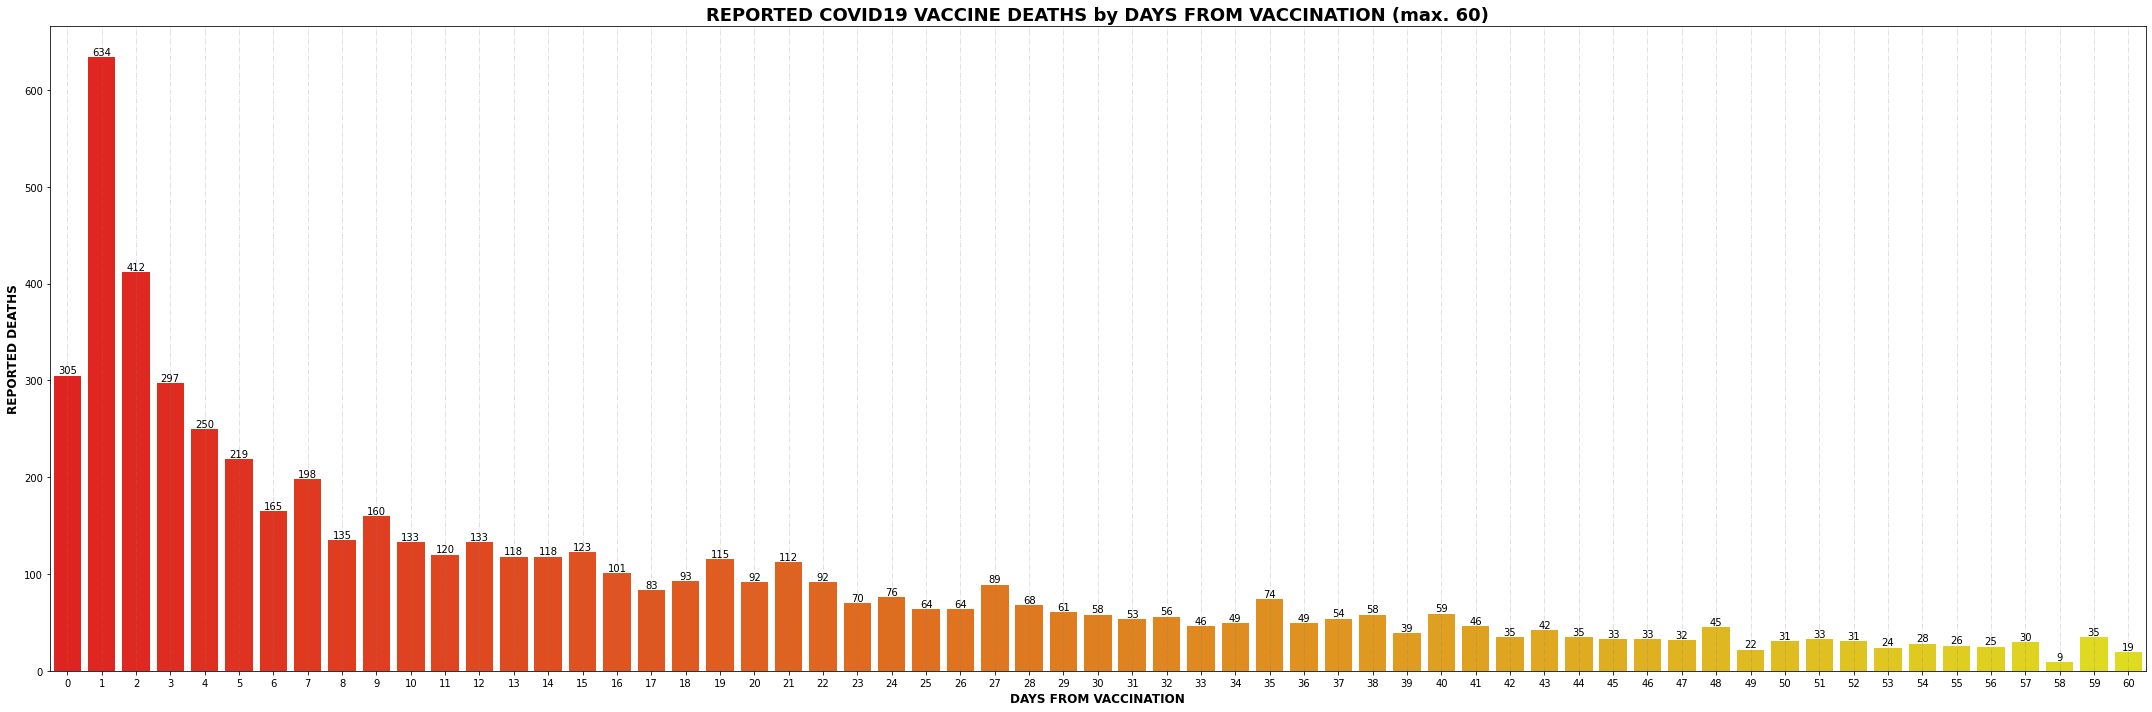

In [24]:
plt.figure(figsize = (30, 10))

ax = sbrn.countplot(x='DAYS_TO_DEATH', data=covidvax_deaths.query("DAYS_TO_DEATH < 61"), palette='autumn')

for container in ax.containers:
    ax.bar_label(container)

plt.title('REPORTED COVID19 VACCINE DEATHS by DAYS FROM VACCINATION (max. 60)', fontweight='bold', fontsize=18)    
plt.xlabel('DAYS FROM VACCINATION', fontweight='bold', fontsize=12)
plt.ylabel('REPORTED DEATHS', fontweight='bold', fontsize=12)
ax.grid(axis='x', color='gray', linestyle='dashdot', alpha=0.3)
plt.tight_layout();

<blockquote><p style="font-family:Verdana; font-size:15px; color:darkblue"><b><i>
Aquí vemos que la mayor parte de los supuestos fallecimientos causados por la vacuna de la COVID-19 se agrupan en los primeros 10-15 días transcurridos desde la vacunación, y se estabilizan en un mínimo a partir de los 30-40 días.<br> 
Aun teniendo en cuenta el cuidado (y el recelo) que hay que tener con estos reportes, estos resultados nos dan una pista de por dónde tirar para contrastarlos con los datos de fallecimientos reales, que abordaremos en los próximos notebooks.

---